In [1]:
def get_aws_credentials():
    """
        Loads AWS credentials from credentials file and sets env variables
    """
    credentials_file = os.getenv("HOME") + '/.aws/credentials'

    try:
        with open(credentials_file, 'r') as f:
            lines = f.read()
        config = dict([tuple([kv.strip() for kv in line.split('=')]) for line in lines.split('\n') if '=' in line])
    except FileNotFoundError:
        config = dict()
    if "aws_access_key_id" in config and "aws_secret_access_key" in config:
        return config["aws_access_key_id"], config["aws_secret_access_key"]
    elif "AWS_ACCESS_KEY_ID" in os.environ and "AWS_SECRET_ACCESS_KEY" in os.environ:
        return os.environ["AWS_ACCESS_KEY_ID"], os.environ["AWS_SECRET_ACCESS_KEY"]
    return None, None

In [2]:
import os
from pyspark.sql import SparkSession

# Set Spark Home
os.environ["SPARK_HOME"] = "/Users/weikun.wang/dev/spark-2.4.3-bin-hadoop2.7"

# Get AWS credentials
aws_access_key_id, aws_secret_access_key = get_aws_credentials()

# Create Spark Session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SparkTest") \
    .config("spark.driver.host", '127.0.0.1') \
    .config("spark.sql.warehouse.dir", "/tmp/spark-warehouse") \
    .config("spark.hadoop.fs.AbstractFileSystem.s3.impl", "org.apache.hadoop.fs.s3a.S3A") \
    .config("spark.hadoop.fs.AbstractFileSystem.s3a.impl", "org.apache.hadoop.fs.s3a.S3A") \
    .config("spark.hadoop.fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.endpoint", "s3.amazonaws.com") \
    .config("spark.hadoop.fs.s3.endpoint", "s3.amazonaws.com") \
    .config("spark.executor.extraJavaOptions", "-Dcom.amazonaws.services.s3.enableV4=true") \
    .config("spark.driver.extraJavaOptions", "-Dcom.amazonaws.services.s3.enableV4=true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.driver.memory", "6g") \
    .config("spark.hadoop.fs.s3.access.key", aws_access_key_id) \
    .config("spark.hadoop.fs.s3.secret.key", aws_secret_access_key) \
    .config("spark.hadoop.fs.s3a.access.key", aws_access_key_id) \
    .config("spark.hadoop.fs.s3a.secret.key", aws_secret_access_key) \
    .getOrCreate()
spark

In [38]:
import pandas as pd

import math
import pickle
import gensim
import random
import seaborn as sns
import numpy as np
from gensim.utils import tokenize
import string
from unidecode import unidecode
from langdetect import detect
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType, ArrayType, DoubleType, MapType, BooleanType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.sql.window import Window

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [4]:
df = spark.read.load("s3://ai-data-lake-dev-eu-west-1/business/company_data_denormalized")

In [5]:
revenue = df[df['total_revenue'] > 1].select('total_revenue').collect()
revenue_log = np.log(revenue)
revenue_percentile = np.percentile(revenue, list(range(5, 100, 10)))

In [6]:
len(revenue)

3065007

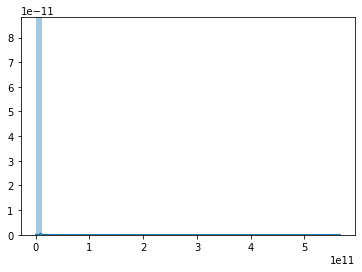

In [7]:
sns.distplot(revenue)

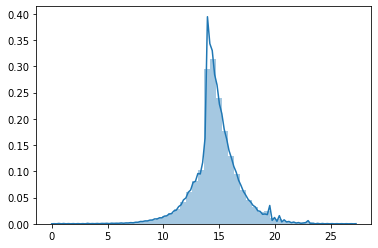

In [8]:
sns.distplot(revenue_log)

In [68]:
num_bins = 100
counts, bin_edges_log = np.histogram(revenue_log, bins=num_bins, normed=True)
bin_edges = np.exp(bin_edges_log)
cdf = np.cumsum(counts)

with open(f"/Users/weikun.wang/Downloads/range_bins_{num_bins}.pickle", "wb") as f:
    pickle.dump(bin_edges, f)

/Users/weikun.wang/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


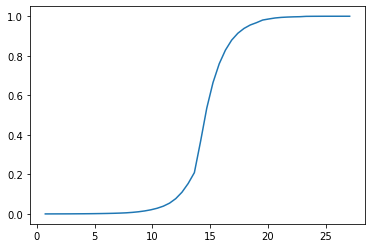

In [61]:
plt.plot(bin_edges_log[1:], cdf/cdf[-1])
plt.show()

In [70]:
def get_range(vals):
    indices = np.searchsorted(bin_edges, vals)
    result = []
    for idx in indices:
        result.append([bin_edges[idx-3], bin_edges[idx+1]])
    return result

In [71]:
ranges = get_range(revenue_percentile)

for rev_per, rev_range in zip(revenue_percentile, ranges):
    print("Value: %s, Range: %s - %s" % ((format(int(rev_per), ",")), (format(int(rev_range[0]), ",")), (format(int(rev_range[1]), ","))))

Value: 84,786, Range: 43,498 - 127,357
Value: 467,469, Range: 217,921 - 638,045
Value: 1,048,693, Range: 487,768 - 1,428,120
Value: 1,361,287, Range: 638,045 - 1,868,110
Value: 1,826,998, Range: 834,620 - 2,443,657
Value: 2,573,823, Range: 1,428,120 - 4,181,344
Value: 3,906,526, Range: 1,868,110 - 5,469,577
Value: 6,724,302, Range: 3,196,525 - 9,358,996
Value: 15,026,437, Range: 7,154,701 - 20,948,004
Value: 85,543,629, Range: 46,887,383 - 137,279,952


In [31]:
print("number if items in the range: " + str(len(revenue)/num_bins*3))

number if items in the range: 183900.41999999998


In [36]:
bin_edges

array([1.22913672e+00, 3.00879637e+00, 7.36521454e+00, 1.80292644e+01,
       4.41337278e+01, 1.08034687e+02, 2.64457460e+02, 6.47363827e+02,
       1.58467802e+03, 3.87912379e+03, 9.49568379e+03, 2.32444272e+04,
       5.68998936e+04, 1.39284907e+05, 3.40954687e+05, 8.34620928e+05,
       2.04306355e+06, 5.00120297e+06, 1.22424147e+07, 2.99681333e+07,
       7.33588132e+07, 1.79574598e+08, 4.39579577e+08, 1.07604420e+09,
       2.63404213e+09, 6.44785590e+09, 1.57836677e+10, 3.86367451e+10,
       9.45786561e+10, 2.31518523e+11, 5.66732801e+11])